[View in Colaboratory](https://colab.research.google.com/github/monajalal/Python_Playground/blob/master/Copy_of_Hello%2C_Colaboratory.ipynb)

## Welcome to Colaboratory!

Colaboratory is a Google research project created to help disseminate machine learning education and research. It's a Jupyter notebook environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

## Local runtime support

Colab also supports connecting to a Jupyter runtime on your local machine. For more information, see our [documentation](https://research.google.com/colaboratory/local-runtimes.html).

## Python 3

Colaboratory supports both Python2 and Python3 for code execution. 

* When creating a new notebook, you'll have the choice between Python 2 and Python 3.
* You can also change the language associated with a notebook; this information will be written into the `.ipynb` file itself, and thus will be preserved for future sessions.

In [0]:
import sys
print('Hello, Colaboratory from Python {}!'.format(sys.version_info[0]))


Hello, Colaboratory from Python 3!


In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 

    100% |████████████████████████████████| 592.3MB 41.9MB/s 


In [0]:
!pip3 install torchvision

    100% |████████████████████████████████| 51kB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 527kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.autograd as autograd
lin = nn.Linear(5, 3) 
data = autograd.Variable(torch.randn(2, 5))
print(lin(data))  

Variable containing:
 0.4711  0.5821 -0.4398
-0.7152 -0.2620  0.0892
[torch.FloatTensor of size 2x3]



In [0]:
!pip install git+https://github.com/pytorch/tnt.git@master

  Cloning https://github.com/pytorch/tnt.git (to master) to /tmp/pip-6e_ypb69-build
    100% |████████████████████████████████| 51kB 2.6MB/s 
  Running setup.py bdist_wheel for visdom ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d3/45/ad/a5b60260d8e6122de5cbafd192ba55aa61d9b23c3b43aff34c
  Running setup.py bdist_wheel for torchfile ... - done
  Stored in directory: /content/.cache/pip/wheels/27/0a/74/650124cbc320716ff2a6566e711a0c84f871647b33ffc868f6
Successfully built visdom torchfile
  Running setup.py install for torchnet ... - \ done


In [0]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 3.6MB/s 


In [1]:
import sys
sys.setrecursionlimit(15000)

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

BATCH_SIZE = 100
NUM_CLASSES = 10
NUM_EPOCHS = 500
NUM_ROUTING_ITERATIONS = 3


def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)


def augmentation(x, max_shift=2):
    _, _, height, width = x.size()

    h_shift, w_shift = np.random.randint(-max_shift, max_shift + 1, size=2)
    source_height_slice = slice(max(0, h_shift), h_shift + height)
    source_width_slice = slice(max(0, w_shift), w_shift + width)
    target_height_slice = slice(max(0, -h_shift), -h_shift + height)
    target_width_slice = slice(max(0, -w_shift), -w_shift + width)

    shifted_image = torch.zeros(*x.size())
    shifted_image[:, :, source_height_slice, source_width_slice] = x[:, :, target_height_slice, target_width_slice]
    return shifted_image.float()


class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs


class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=32 * 6 * 6, in_channels=8,
                                           out_channels=16)

        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.sparse.torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))

        return classes, reconstructions


class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, images, labels, classes, reconstructions):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        assert torch.numel(images) == torch.numel(reconstructions)
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)


if __name__ == "__main__":
    from torch.autograd import Variable
    from torch.optim import Adam
    from torchnet.engine import Engine
    from torchnet.logger import VisdomPlotLogger, VisdomLogger
    from torchvision.utils import make_grid
    from torchvision.datasets.mnist import MNIST
    from tqdm import tqdm
    import torchnet as tnt

    model = CapsuleNet()
    # model.load_state_dict(torch.load('epochs/epoch_327.pt'))
    model.cuda()

    print("# parameters:", sum(param.numel() for param in model.parameters()))

    optimizer = Adam(model.parameters())

    engine = Engine()
    meter_loss = tnt.meter.AverageValueMeter()
    meter_accuracy = tnt.meter.ClassErrorMeter(accuracy=True)
    confusion_meter = tnt.meter.ConfusionMeter(NUM_CLASSES, normalized=True)

    train_loss_logger = VisdomPlotLogger('line', opts={'title': 'Train Loss'})
    train_error_logger = VisdomPlotLogger('line', opts={'title': 'Train Accuracy'})
    test_loss_logger = VisdomPlotLogger('line', opts={'title': 'Test Loss'})
    test_accuracy_logger = VisdomPlotLogger('line', opts={'title': 'Test Accuracy'})
    confusion_logger = VisdomLogger('heatmap', opts={'title': 'Confusion matrix',
                                                     'columnnames': list(range(NUM_CLASSES)),
                                                     'rownames': list(range(NUM_CLASSES))})
    ground_truth_logger = VisdomLogger('image', opts={'title': 'Ground Truth'})
    reconstruction_logger = VisdomLogger('image', opts={'title': 'Reconstruction'})

    capsule_loss = CapsuleLoss()


    def get_iterator(mode):
        dataset = MNIST(root='./data', download=True, train=mode)
        data = getattr(dataset, 'train_data' if mode else 'test_data')
        labels = getattr(dataset, 'train_labels' if mode else 'test_labels')
        tensor_dataset = tnt.dataset.TensorDataset([data, labels])

        return tensor_dataset.parallel(batch_size=BATCH_SIZE, num_workers=4, shuffle=mode)


    def processor(sample):
        data, labels, training = sample

        data = augmentation(data.unsqueeze(1).float() / 255.0)
        labels = torch.LongTensor(labels)

        labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)

        data = Variable(data).cuda()
        labels = Variable(labels).cuda()

        if training:
            classes, reconstructions = model(data, labels)
        else:
            classes, reconstructions = model(data)

        loss = capsule_loss(data, labels, classes, reconstructions)

        return loss, classes


    def reset_meters():
        meter_accuracy.reset()
        meter_loss.reset()
        confusion_meter.reset()


    def on_sample(state):
        state['sample'].append(state['train'])


    def on_forward(state):
        meter_accuracy.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        confusion_meter.add(state['output'].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].data[0])


    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'])


    def on_end_epoch(state):
        print('[Epoch %d] Training Loss: %.4f (Accuracy: %.2f%%)' % (
            state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))

        train_loss_logger.log(state['epoch'], meter_loss.value()[0])
        train_error_logger.log(state['epoch'], meter_accuracy.value()[0])

        reset_meters()

        engine.test(processor, get_iterator(False))
        test_loss_logger.log(state['epoch'], meter_loss.value()[0])
        test_accuracy_logger.log(state['epoch'], meter_accuracy.value()[0])
        confusion_logger.log(confusion_meter.value())

        print('[Epoch %d] Testing Loss: %.4f (Accuracy: %.2f%%)' % (
            state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))

        torch.save(model.state_dict(), 'epochs/epoch_%d.pt' % state['epoch'])

        # Reconstruction visualization.

        test_sample = next(iter(get_iterator(False)))

        ground_truth = (test_sample[0].unsqueeze(1).float() / 255.0)
        _, reconstructions = model(Variable(ground_truth).cuda())
        reconstruction = reconstructions.cpu().view_as(ground_truth).data

        ground_truth_logger.log(
            make_grid(ground_truth, nrow=int(BATCH_SIZE ** 0.5), normalize=True, range=(0, 1)).numpy())
        reconstruction_logger.log(
            make_grid(reconstruction, nrow=int(BATCH_SIZE ** 0.5), normalize=True, range=(0, 1)).numpy())

    # def on_start(state):
    #     state['epoch'] = 327
    #
    # engine.hooks['on_start'] = on_start
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch

    engine.train(processor, get_iterator(True), maxepoch=NUM_EPOCHS, optimizer=optimizer)


  0%|          | 0/600 [00:00<?, ?it/s]

# parameters: 8215568


100%|██████████| 600/600 [06:05<00:00,  1.64it/s]

[Epoch 1] Training Loss: 0.5197 (Accuracy: 89.19%)
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connection.py", line 141, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 83, in create_connection
    raise err
  File "/usr/local/lib/python3.6/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 601, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py", line 357, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  Fil

RuntimeError: ignored

## TensorFlow execution

Colaboratory allows you to execute TensorFlow code in your browser with a single click. The example below adds two matrices.

$\begin{bmatrix}
  1. & 1. & 1. \\
  1. & 1. & 1. \\
\end{bmatrix} +
\begin{bmatrix}
  1. & 2. & 3. \\
  4. & 5. & 6. \\
\end{bmatrix} =
\begin{bmatrix}
  2. & 3. & 4. \\
  5. & 6. & 7. \\
\end{bmatrix}$

In [0]:
import tensorflow as tf
import numpy as np

with tf.Session():
  input1 = tf.constant(1.0, shape=[2, 3])
  input2 = tf.constant(np.reshape(np.arange(1.0, 7.0, dtype=np.float32), (2, 3)))
  output = tf.add(input1, input2)
  result = output.eval()

result

array([[ 2.,  3.,  4.],
       [ 5.,  6.,  7.]], dtype=float32)

## Visualization

Colaboratory includes widely used libraries like [matplotlib](https://matplotlib.org/), simplifying visualization.

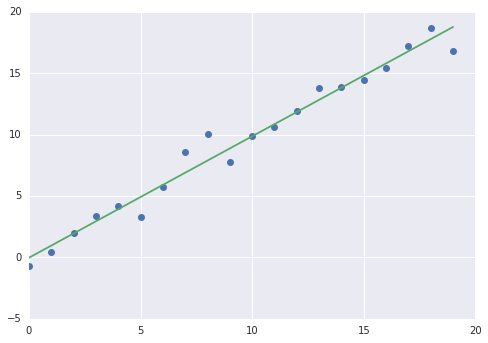

In [0]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(20)
y = [x_i + np.random.randn(1) for x_i in x]
a, b = np.polyfit(x, y, 1)
_ = plt.plot(x, y, 'o', np.arange(20), a*np.arange(20)+b, '-')

Want to use a new library?  `pip install` it. For recipes to import commonly used libraries, refer to the [importing libraries example notebook](/notebooks/snippets/importing_libraries.ipynb)

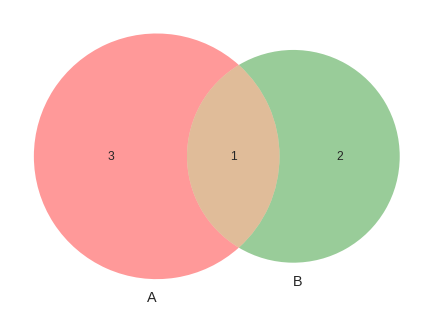

In [0]:
# Only needs to be run once at the top of the notebook.
!pip install -q matplotlib-venn

# Now the newly-installed library can be used anywhere else in the notebook.
from matplotlib_venn import venn2
_ = venn2(subsets = (3, 2, 1))

# Forms

Forms can be used to parameterize code. See the [forms example notebook](/notebooks/forms.ipynb) for more details.

In [0]:
#@title Examples

text = 'value' #@param 
date_input = '2018-03-22' #@param {type:"date"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]


# For more information:
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Markdown guide](/notebooks/markdown_guide.ipynb)
- [Charts](/notebooks/charts.ipynb)
- [Widgets](/notebooks/widgets.ipynb)
- [Loading and saving data: local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Example Google Cloud BigQuery notebook](/notebooks/bigquery.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)
- [Forms](/notebooks/forms.ipynb)